In [9]:
%load_ext autoreload
%autoreload 2
import TRITON_SWMM_toolkit.examples as examples
import TRITON_SWMM_toolkit.analysis as analysis
from TRITON_SWMM_toolkit.process_simulation import TRITONSWMM_sim_post_processing
import TRITON_SWMM_toolkit.process_simulation as ps
import TRITON_SWMM_toolkit.processing_analysis as pe
from TRITON_SWMM_toolkit.process_simulation import *
import TRITON_SWMM_toolkit.plot_utils as plot_utils
import TRITON_SWMM_toolkit.utils as utils 

from importlib import reload
reload(examples)
reload(analysis)
reload(ps)
reload(pe)
reload(plot_utils)
reload(utils)
norfolk_singlesim = examples.TRITON_SWMM_testcases.retreive_norfolk_single_sim_test_case(download_if_exists=False)
norfolk_multisim = examples.TRITON_SWMM_testcases.retreive_norfolk_multi_sim_test_case()

sim_iloc = 0
exp = norfolk_multisim.system.analysis

self = exp.plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Axes: >

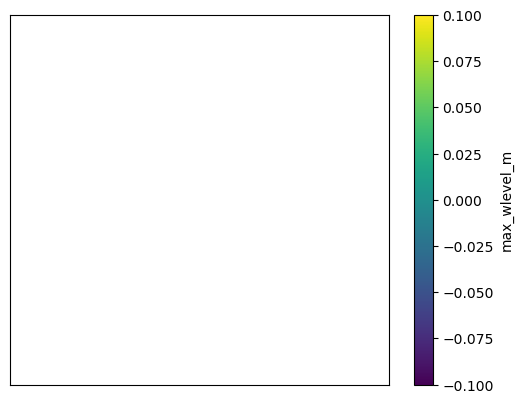

In [18]:
da = self.triton_ds["max_wlevel_m"].isel(sim_iloc=1)
mask = utils.create_mask_from_shapefile(da, self._system.cfg_system.watershed_gis_polygon)

plot_utils.plot_continuous_raster(da.where(mask & (da>0)), cbar_lab="max_wlevel_m")

In [49]:
ds_event_weather_series = xr.open_dataset(self._analysis.cfg_exp.weather_timeseries)
# self._analysis._system.cfg_system.display_tabulate_cfg()

n_reporting_tsteps_per_sim = 5

df_raingage_mapping = pd.read_csv(self._analysis._system.cfg_system.subcatchment_raingage_mapping)
gages = df_raingage_mapping[self._analysis._system.cfg_system.subcatchment_raingage_mapping_gage_id_colname].unique()

wlevel_name = (
            self._analysis.cfg_exp.weather_time_series_storm_tide_datavar
        )

reporting_tstep_min = (
    self._analysis.cfg_exp.TRITON_reporting_timestep_s / 60
)
tstep_coord_name = (
            self._analysis.cfg_exp.weather_time_series_timestep_dimension_name
        )
gage_colname = (
            self._analysis._system.cfg_system.subcatchment_raingage_mapping_gage_id_colname
        )
timesteps = pd.date_range(start = "2000-01-01", periods = n_reporting_tsteps_per_sim+1, freq = f"{int(reporting_tstep_min)}min")

columns = list(gages) + [wlevel_name]

df_tseries = pd.DataFrame(index = timesteps, columns = columns)

df_tseries.loc[:, wlevel_name] = 5
df_tseries.loc[:, gages] = 1000
df_tseries.index.name = tstep_coord_name
df_tseries.to_xarray()

<xarray.Dataset> Size: 384B
Dimensions:       (timestep: 6)
Coordinates:
  * timestep      (timestep) datetime64[ns] 48B 2000-01-01 ... 2000-01-01T00:...
Data variables:
    156           (timestep) object 48B 1000 1000 1000 1000 1000 1000
    171           (timestep) object 48B 1000 1000 1000 1000 1000 1000
    170           (timestep) object 48B 1000 1000 1000 1000 1000 1000
    155           (timestep) object 48B 1000 1000 1000 1000 1000 1000
    140           (timestep) object 48B 1000 1000 1000 1000 1000 1000
    141           (timestep) object 48B 1000 1000 1000 1000 1000 1000
    waterlevel_m  (timestep) object 48B 5 5 5 5 5 5